# Preliminaries: Inspect and Set up environment

In [1]:
# Import all libraries required

# Data Processing and EDA
import datetime
import pandas as pd
import numpy as np

# For bioinformatics tasks
from Bio import SeqIO
# older alignment method
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# newer alignment method - not using this, 
# but just don't want to forget this option
from Bio import Align
from Bio.Align import PairwiseAligner
import multiprocessing

# For Machine Learning
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# For Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from seaborn import heatmap
from sklearn.inspection import partial_dependence
import matplotlib.pyplot as plt

/home/ajvilleg/miniforge3/envs/learn-flu/lib/python3.12/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
# Environment
# Show all the output for every print not just the last
from IPython.core.interactiveshell import InteractiveShell
# Configuration and settings
InteractiveShell.ast_node_interactivity = "all"
# To check if in Google Colab
from IPython.core.getipython import get_ipython
# To display all the output in a nicer table
from IPython.display import display
# To time the execution of the code
import time
import os.path

In [3]:
print(datetime.datetime.now())

2024-07-30 15:49:58.949160


In [4]:
!which python

/home/ajvilleg/miniforge3/envs/learn-flu/bin/python


In [5]:
!python --version

Python 3.12.2


In [6]:
!echo $PYTHONPATH

In [7]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [8]:
#if 'google.colab' in str(get_ipython()):
    # TODO: if running on Google Colab, install any packages you need to here. For example:
    #!pip install unidecode
    #!pip install category_encoders
    #!pip install scikeras

In [9]:
# Let's minimize randomness
# numpy
np.random.seed(42)

Start the timer

In [10]:
# Start timing the entire process
start_time = time.time()

# 1.0 Data Understanding

## 1.1 Load data

In [11]:
# Parse the FASTA file
records = list(SeqIO.parse("/home/ajvilleg/Netdrive/AI/GISAID/EpiFlu_Training/28-Jul-2024/gisaid_epiflu_sequence_28-Jul-2024_USA.fasta", "fasta"))


In [12]:
def check_duplicate_headers(records):
    """Checks for duplicate FASTA headers in a list of SeqIO records.

    Args:
        records: A list of SeqRecord objects.

    Returns:
        list: A list of indices corresponding to duplicate records.
        list: A list of duplicate headers.
    """
    seen = set()
    duplicates = []
    duplicate_headers = []
    for i, record in enumerate(records):
        header = record.description  # Or use record.id
        if header in seen:
            duplicates.append(i)
            duplicate_headers.append(header)
        else:
            seen.add(header)
    return duplicates, duplicate_headers

In [13]:
# Check for duplicates before extracting details
duplicate_indices, duplicate_headers = check_duplicate_headers(records)
if duplicate_indices:
    print("Warning: Found the following duplicate FASTA headers:")
    for header in duplicate_headers:
        print(header)
    print("One copy of each duplicate record will be kept.")

    # Create a set of unique indices to keep
    indices_to_keep = set(range(len(records))) - set(duplicate_indices)

    # Filter the records list
    records = [record for i, record in enumerate(records) if i in indices_to_keep]
    print("Duplicate records have been removed, keeping one copy of each.")


A/Florida/35/2014|EPI_ISL_249765|A_/_H3N2||NA|2014-09-23|3C.3a
A/Florida/35/2014|EPI_ISL_249765|A_/_H3N2||HA|2014-09-23|3C.3a
A/Florida/35/2014|EPI_ISL_249765|A_/_H3N2||NA|2014-09-23|3C.3a
A/Florida/35/2014|EPI_ISL_249765|A_/_H3N2||HA|2014-09-23|3C.3a
A/Pennsylvania/40/2014|EPI_ISL_249771|A_/_H3N2||NA|2014-09-13|3C.2
A/Pennsylvania/40/2014|EPI_ISL_249771|A_/_H3N2||HA|2014-09-13|3C.2
A/Minnesota/22/2014|EPI_ISL_249770|A_/_H3N2||HA|2014-09-20|3C.2
A/Minnesota/22/2014|EPI_ISL_249770|A_/_H3N2||NA|2014-09-20|3C.2
A/Minnesota/21/2014|EPI_ISL_249773|A_/_H3N2||NA|2014-09-17|3C.2
A/Minnesota/21/2014|EPI_ISL_249773|A_/_H3N2||HA|2014-09-17|3C.2
A/New_Mexico/27/2014|EPI_ISL_249777|A_/_H3N2||HA|2014-09-18|3C.2
A/New_Mexico/27/2014|EPI_ISL_249777|A_/_H3N2||NA|2014-09-18|3C.2
A/Wisconsin/20/2015|EPI_ISL_200659|A_/_H3N2||NA|2015-02-24|3C.2
A/Wisconsin/20/2015|EPI_ISL_200659|A_/_H3N2||HA|2015-02-24|3C.2
A/Connecticut/21/2014|EPI_ISL_249815|A_/_H3N2||NA|2014-10-14|3C.2
A/Connecticut/21/2014|EPI_ISL_2498

In [14]:
# Extract the details from the description of each record
data = []

# Iterate through records for every pair for NA and HA segments
for record1, record2 in zip(records[::2], records[1::2]):
    description1 = record1.description.split('|')
    description2 = record2.description.split('|')

    # Assume the isolate name is the same for both segments
    isolate_name1 = description1[0].strip()
    isolate_name2 = description2[0].strip()
    if isolate_name1 != isolate_name2:
        print(f"Isolate names do not match: {isolate_name1} vs {isolate_name2}")
        raise ValueError("Isolate names do not match")

    # Assume the isolate ID is the same for both segments
    isolate_id1 = description1[1].strip()
    isolate_id2 = description2[1].strip()
    if isolate_id1 != isolate_id2:
        print(f"Isolate IDs do not match: {isolate_id1} vs {isolate_id2}")
        raise ValueError("Isolate IDs do not match")

    # Assume the flu type is the same for both segments
    flu_type1 = description1[2].strip()
    flu_type2 = description2[2].strip()
    if flu_type1 != flu_type2:
        print(f"Flu types do not match: {flu_type1} vs {flu_type2}")
        raise ValueError("Flu types do not match")

    # Assume the lineage is the same for both segments
    lineage1 = description1[3].strip()
    lineage2 = description2[3].strip()
    if lineage1 != lineage2:
        print(f"Lineages do not match: {lineage1} vs {lineage2}")
        raise ValueError("Lineages do not match")

    # The segment labels are different for NA and HA segments
    segment1 = description1[4].strip()
    segment2 = description2[4].strip()  

    # Assume the collection date is the same for both segments
    collection_date1 = description1[5].strip()
    collection_date2 = description2[5].strip()
    if collection_date1 != collection_date2:
        print(f"Collection dates do not match: {collection_date1} vs {collection_date2}")
        raise ValueError("Collection dates do not match")

    # Assume the clade is the same for both segments. This is important as this will be our label for classification
    clade1 = description1[6].strip()
    clade2 = description2[6].strip()
    if clade1 != clade2:
        print(f"Clades do not match: {clade1} vs {clade2}")
        raise ValueError("Clades do not match")

    # The sequences will be different corresopnding to the NA and HA segments
    sequence1 = str(record1.seq)
    sequence2 = str(record2.seq)
    if segment1 == 'HA':
        sequence_ha = sequence1
        sequence_na = sequence2
    else: # segment2 == 'HA'
        sequence_ha = sequence2
        sequence_na = sequence1
    data.append([isolate_name1, isolate_id1, flu_type1, lineage1, sequence_ha, sequence_na, collection_date1, clade1])

df = pd.DataFrame(data, columns=['Isolate_Name', 'Isolate_ID', 'Flu_Type', 'Lineage', 'HA', 'NA', 'Collection Date', 'Clade'])

In [15]:
# Take a look at the data  
display(df)

,Isolate_Name,Isolate_ID,Flu_Type,Lineage,HA,NA,Collection Date,Clade
0,A/Indiana/18/2016,EPI_ISL_212995,A_/_H3N2,,ggataattctattaaccatgaagactatcattgctttgagctacat...,agtaaagatgaatccaaatcaaaagataataacgattggctctgtt...,2016-01-25,3C.2a
1,A/Indiana/17/2016,EPI_ISL_212994,A_/_H3N2,,ggataattctattaaccatgaagactatcattgccttgagctacat...,agtaaagatgaatccaaatcaaaagataataacgattggctctgtt...,2016-01-25,3C.2a
2,A/Indiana/16/2016,EPI_ISL_212993,A_/_H3N2,,ggataattctattaaccatgaagactatcattgccttgagctacat...,agtaaagatgaatccaaatcaaaagataataacgattggctctgtt...,2016-01-22,3C.2a
3,A/Maine/43/2015,EPI_ISL_212998,A_/_H3N2,,ggataattctattaaccatgaagactatcattgctttgagctacat...,agtaaagatgaatccaaatcaaaagataataacgattggctctgtt...,2015-10-19,3C.2
4,A/Louisiana/11/2015,EPI_ISL_212997,A_/_H3N2,,ggataattctattaaccatgaagactatcattgctttgagctacat...,agtaaagatgaatccaaatcaaaagataataacgattggctctgtt...,2015-12-19,3C.2
...,...,...,...,...,...,...,...,...
67349,A/Michigan/MISAPPHIREL365130699/2023,EPI_ISL_18104010,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,atgaatccaaaccaaaagataataaccattggttctatttgtatga...,2023-05-05,6B.1A.5a.2a.1
67350,A/Michigan/MISAPPHIREL365192713/2023,EPI_ISL_18104011,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,atgaatccaaaccaaaagataataaccattggttctatctgtatga...,2023-05-08,6B.1A.5a.2a
67351,A/Michigan/UM-L369095950/2023,EPI_ISL_18759394,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,atgaatccaaaccaaaagataataaccattggttctgtttgtatga...,2023-09-06,6B.1A.5a.2a.1
67352,A/Michigan/UM-10053791527/2023,EPI_ISL_18759392,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,atgaatccaaaccaaaagataataaccattggttctatttgtatga...,2023-10-09,6B.1A.5a.2a.1


In [16]:
# Extract Type using regular expressions
df['Type'] = df['Flu_Type'].astype(str).str.extract(r'(A|B|C)').fillna('')

In [17]:
# Extract H_Subtype and N_Subtype with updated regex, allowing for one or more digits after H or N.
df['H_Subtype'] = df['Flu_Type'].astype(str).str.extract(r'(H\d+)').fillna('')
df['N_Subtype'] = df['Flu_Type'].astype(str).str.extract(r'(N\d+)').fillna('')
print(df['H_Subtype'].value_counts().to_markdown(numalign="left", stralign="left"))
print(df['N_Subtype'].value_counts().to_markdown(numalign="left", stralign="left"))

| H_Subtype   | count   |
|:------------|:--------|
| H3          | 41660   |
| H1          | 25686   |
| H5          | 7       |
| H7          | 1       |
| N_Subtype   | count   |
|:------------|:--------|
| N2          | 41693   |
| N1          | 25661   |


In [18]:
# Take a look at the data again
display(df)

,Isolate_Name,Isolate_ID,Flu_Type,Lineage,HA,NA,Collection Date,Clade,Type,H_Subtype,N_Subtype
0,A/Indiana/18/2016,EPI_ISL_212995,A_/_H3N2,,ggataattctattaaccatgaagactatcattgctttgagctacat...,agtaaagatgaatccaaatcaaaagataataacgattggctctgtt...,2016-01-25,3C.2a,A,H3,N2
1,A/Indiana/17/2016,EPI_ISL_212994,A_/_H3N2,,ggataattctattaaccatgaagactatcattgccttgagctacat...,agtaaagatgaatccaaatcaaaagataataacgattggctctgtt...,2016-01-25,3C.2a,A,H3,N2
2,A/Indiana/16/2016,EPI_ISL_212993,A_/_H3N2,,ggataattctattaaccatgaagactatcattgccttgagctacat...,agtaaagatgaatccaaatcaaaagataataacgattggctctgtt...,2016-01-22,3C.2a,A,H3,N2
3,A/Maine/43/2015,EPI_ISL_212998,A_/_H3N2,,ggataattctattaaccatgaagactatcattgctttgagctacat...,agtaaagatgaatccaaatcaaaagataataacgattggctctgtt...,2015-10-19,3C.2,A,H3,N2
4,A/Louisiana/11/2015,EPI_ISL_212997,A_/_H3N2,,ggataattctattaaccatgaagactatcattgctttgagctacat...,agtaaagatgaatccaaatcaaaagataataacgattggctctgtt...,2015-12-19,3C.2,A,H3,N2
...,...,...,...,...,...,...,...,...,...,...,...
67349,A/Michigan/MISAPPHIREL365130699/2023,EPI_ISL_18104010,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,atgaatccaaaccaaaagataataaccattggttctatttgtatga...,2023-05-05,6B.1A.5a.2a.1,A,H1,N1
67350,A/Michigan/MISAPPHIREL365192713/2023,EPI_ISL_18104011,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,atgaatccaaaccaaaagataataaccattggttctatctgtatga...,2023-05-08,6B.1A.5a.2a,A,H1,N1
67351,A/Michigan/UM-L369095950/2023,EPI_ISL_18759394,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,atgaatccaaaccaaaagataataaccattggttctgtttgtatga...,2023-09-06,6B.1A.5a.2a.1,A,H1,N1
67352,A/Michigan/UM-10053791527/2023,EPI_ISL_18759392,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,atgaatccaaaccaaaagataataaccattggttctatttgtatga...,2023-10-09,6B.1A.5a.2a.1,A,H1,N1


## 1.2 EDA

### 1.2.1 Dataframe structure

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67354 entries, 0 to 67353
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Isolate_Name     67354 non-null  object
 1   Isolate_ID       67354 non-null  object
 2   Flu_Type         67354 non-null  object
 3   Lineage          67354 non-null  object
 4   HA               67354 non-null  object
 5   NA               67354 non-null  object
 6   Collection Date  67354 non-null  object
 7   Clade            67354 non-null  object
 8   Type             67354 non-null  object
 9   H_Subtype        67354 non-null  object
 10  N_Subtype        67354 non-null  object
dtypes: object(11)
memory usage: 5.7+ MB


In [20]:
# Convert all columns to strings except Collection Date
df = df.astype(str)

# Convert "Collection Date" column to date
df["Collection Date"] = pd.to_datetime(df["Collection Date"])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67354 entries, 0 to 67353
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Isolate_Name     67354 non-null  object        
 1   Isolate_ID       67354 non-null  object        
 2   Flu_Type         67354 non-null  object        
 3   Lineage          67354 non-null  object        
 4   HA               67354 non-null  object        
 5   NA               67354 non-null  object        
 6   Collection Date  67354 non-null  datetime64[ns]
 7   Clade            67354 non-null  object        
 8   Type             67354 non-null  object        
 9   H_Subtype        67354 non-null  object        
 10  N_Subtype        67354 non-null  object        
dtypes: datetime64[ns](1), object(10)
memory usage: 5.7+ MB


### 1.2.2 Describe

In [21]:
df.describe()

,Collection Date
count,67354
mean,2019-09-15 23:36:13.554651648
min,2009-04-09 00:00:00
25%,2017-04-25 00:00:00
50%,2019-12-18 00:00:00
75%,2022-12-12 00:00:00
max,2024-07-22 00:00:00


### 1.2.3 Duplicated rows

In [22]:
# Check for duplicated rows in training data
print(f'df has {df.duplicated().sum()} duplicate rows')
display(df[df.duplicated()])
# Drop duplicates and check again
df.drop_duplicates(inplace=True)
print(f'df has {df.duplicated().sum()} duplicate rows')

df has 0 duplicate rows


,Isolate_Name,Isolate_ID,Flu_Type,Lineage,HA,NA,Collection Date,Clade,Type,H_Subtype,N_Subtype


df has 0 duplicate rows


### 1.2.4 Missing values / NaN / Empty Strings

In [23]:
# Check for missing values and empty strings
print("NaN values in df:")
print(df.isnull().sum())  # Check for NaN values
print("\nEmpty string values in df:")
for col in df.select_dtypes(include=['object']):  # Iterate over columns with string datatype
    print(f"{col}: {(df[col] == '').sum()}")     # Count empty strings

NaN values in df:
Isolate_Name       0
Isolate_ID         0
Flu_Type           0
Lineage            0
HA                 0
NA                 0
Collection Date    0
Clade              0
Type               0
H_Subtype          0
N_Subtype          0
dtype: int64

Empty string values in df:
Isolate_Name: 0
Isolate_ID: 0
Flu_Type: 0
Lineage: 41699
HA: 0
NA: 0
Clade: 22
Type: 0
H_Subtype: 0
N_Subtype: 0


In [24]:
# Drop rows with nulls or empty strings in Clade, ignore Lineage nulls/empty strings
df.replace('', pd.NA, inplace=True)  # Replace empty strings with NaN
df.dropna(subset=['Clade'], inplace=True)  # Drop rows where Clade is NaN

In [25]:
# Check for missing values and empty strings
# NOTE: the previous empty strings that were not removed will now show up as NaN as we replaced empty strings with NaN
print("NaN values in df:")
print(df.isnull().sum())  # Check for NaN values
print("\nEmpty string values in df:")
for col in df.select_dtypes(include=['object']):  # Iterate over columns with string datatype
    print(f"{col}: {(df[col] == '').sum()}")     # Count empty strings

NaN values in df:
Isolate_Name           0
Isolate_ID             0
Flu_Type               0
Lineage            41684
HA                     0
NA                     0
Collection Date        0
Clade                  0
Type                   0
H_Subtype              0
N_Subtype              0
dtype: int64

Empty string values in df:
Isolate_Name: 0
Isolate_ID: 0
Flu_Type: 0
Lineage: 0
HA: 0
NA: 0
Clade: 0
Type: 0
H_Subtype: 0
N_Subtype: 0


### 1.2.5 Class Imbalance

#### Clade Imbalance

In [26]:
df['Clade'].value_counts()

Clade
6B.1A.5a.2a.1         8088
6B.1                  5679
3C.2a1b.2a.2b         5537
3C.2a1b.2a.2a.1a      5379
3C.2a1b.2a.2a.3a.1    4987
3C.2                  4797
3C.2a2                4143
3C.3a1                4071
3C.3a                 2832
3C.2a1                2511
6B.1A.5a.2a           2386
6B.1A.1               1934
6B.1A.5a.1            1560
3C.2a1b.2a.2a.1       1520
6B.1A.5b              1470
6B.1A.5a.2            1213
3C.2a1b.2a.2a.3       1096
6B.1A.5a              1071
3C.2a1b.2b             756
6B.1A                  660
3C.2a                  615
6B.1A.7                567
3C.2a1b.2a.2a.1b       538
3C.2a1b.2              472
6B.1A.6                460
3C.2a1b.1              447
3C.2a1b.2a.2a          425
3C.2a3                 397
6B.1A.3                285
3C.2a1b.2a             208
3C.2a1b.2a.2a.3b       206
3C.2a1b.1b             202
3C.2a1b.1a             180
unassigned             113
3C.2a1b.2a.2a.3a       109
6B.1A.2                 97
3C.2a1b.2a.2c         

In [27]:
# Drop rows with "unassigned" in 'Clade' from the training data
df = df[df['Clade'] != 'unassigned']  # Filter out rows with label "unassigned"

In [28]:
df['Clade'].value_counts()

Clade
6B.1A.5a.2a.1         8088
6B.1                  5679
3C.2a1b.2a.2b         5537
3C.2a1b.2a.2a.1a      5379
3C.2a1b.2a.2a.3a.1    4987
3C.2                  4797
3C.2a2                4143
3C.3a1                4071
3C.3a                 2832
3C.2a1                2511
6B.1A.5a.2a           2386
6B.1A.1               1934
6B.1A.5a.1            1560
3C.2a1b.2a.2a.1       1520
6B.1A.5b              1470
6B.1A.5a.2            1213
3C.2a1b.2a.2a.3       1096
6B.1A.5a              1071
3C.2a1b.2b             756
6B.1A                  660
3C.2a                  615
6B.1A.7                567
3C.2a1b.2a.2a.1b       538
3C.2a1b.2              472
6B.1A.6                460
3C.2a1b.1              447
3C.2a1b.2a.2a          425
3C.2a3                 397
6B.1A.3                285
3C.2a1b.2a             208
3C.2a1b.2a.2a.3b       206
3C.2a1b.1b             202
3C.2a1b.1a             180
3C.2a1b.2a.2a.3a       109
6B.1A.2                 97
3C.2a1b.2a.2c           83
3C.2a1b.2a.2a.2       

#### H_Subtype Imbalance

In [29]:
df['H_Subtype'].value_counts()

H_Subtype
H3    41630
H1    25582
H5        7
Name: count, dtype: int64

#### N_Subtype Imbalance

In [30]:
df['N_Subtype'].value_counts()

N_Subtype
N2    41654
N1    25565
Name: count, dtype: int64

### 1.2.6 Shape

In [31]:
df.shape

(67219, 11)

### 1.2.7 Look at sequence length stats

In [32]:
def get_sequence_length(row, column):
    """Calculates the length of the sequence in the specified column."""
    return len(row[column])

ha_sequence_lengths = df.apply(get_sequence_length, axis=1, column="HA")
na_sequence_lengths = df.apply(get_sequence_length, axis=1, column="NA")
print("Sequence lengths in HA columns:")
ha_sequence_lengths.describe()
print("Sequence lengths in NA columns:")
na_sequence_lengths.describe()


Sequence lengths in HA columns:


count    67219.000000
mean      1728.941103
std         22.475835
min       1656.000000
25%       1701.000000
50%       1737.000000
75%       1752.000000
max       1972.000000
dtype: float64

Sequence lengths in NA columns:


count    67219.000000
mean      1428.618337
std         16.079264
min       1362.000000
25%       1410.000000
50%       1433.000000
75%       1441.000000
max       1624.000000
dtype: float64

# 2.0 Data Preparation

### 2.1 K-mers and k-mer encoding

In [33]:
# Define k-mer length
# kmer_length = 12
kmer_length = 6

In [34]:
# Function to extract kmers (can be reused)
def get_kmers(sequence, k):
  """
  Extracts all k-mers (subsequences of length k) from a DNA sequence.
  """
  kmers = []
  for i in range(len(sequence) - k + 1):
    kmer = sequence[i:i+k]
    kmers.append(kmer)
  return kmers

In [35]:
# Create an empty dictionary to store kmers for each sequence (identified by row index)
kmer_dict = {}

In [36]:
# Extract k-mers with length kmer_length from each sequence and store them in the dictionary
for i, row in df.iterrows():
  # Extract kmers from HA sequence (assuming it exists)
  ha_kmers = []
  if "HA" in row:  # Check if "HA" column exists
    sequence = str(row["HA"])
    ha_kmers = get_kmers(sequence, kmer_length)

  # Store kmers separately in the dictionary
  kmer_dict[i] = {
    "HA": ha_kmers
  }

In [37]:
df.loc[22, "HA"]


'agcaaaagcaggggataattctattaaccatgaagactatcattgctttgagctacattttatgtctggttttcgctcaaaaacttcccggaaatgacaacagcacggcaacgctgtgcctgggacaccatgcagtgccaaacggaacgctagtgaaaacaatcacgaatgaccaaattgaagtgactaatgctactgagctggttcagagttcctcaacaggtagaatatgcgacagtcctcaccaaatccttgatggagaaaactgcacactgatagatgctctattgggagacccacattgtgatggcttccaaaataaggaatgggacctttttgttgaacgcagcaaagcctacagcaactgttacccttatgatgtgccggattatgcctcccttaggtcactagttgcctcatccggcaccctggagtttaacaatgaaagcttcaattggactggagtcgctcagaatggaacaagctctgcttgcaaaaggagatctattaacagtttctttagtagattgaattggttgcaccaattaaaatacagatatccagcactgaacgtgactatgccaaacaatgacaaatttgacaaattgtacatttggggggttcaccacccgagtacggacagtgaccaaaccagcctatatacccaagcatcagggagagtcacagtctctaccaaaagaagccaacaaactgtaatcccgaatatcggatccagaccctgggtaaggggtatctccagcagaataagcatctattggacaatagtaaaaccgggagacatacttttgattaaaagcacagggaatctaattgctcctcggggttacttcaaaatacgaagtgggaaaagctcaataatgaggtcagatgcacccattggcaaatgcaattctgaatgcatcactccaaatggaagcattcccaatgacaaaccatttcaaaatgtaaacaggatcacatatggggcctgtcccagat

In [38]:
row_index = 22  # Replace with the desired row index
kmer_breakdown = kmer_dict[row_index]
print(kmer_breakdown)

{'HA': ['agcaaa', 'gcaaaa', 'caaaag', 'aaaagc', 'aaagca', 'aagcag', 'agcagg', 'gcaggg', 'cagggg', 'agggga', 'ggggat', 'gggata', 'ggataa', 'gataat', 'ataatt', 'taattc', 'aattct', 'attcta', 'ttctat', 'tctatt', 'ctatta', 'tattaa', 'attaac', 'ttaacc', 'taacca', 'aaccat', 'accatg', 'ccatga', 'catgaa', 'atgaag', 'tgaaga', 'gaagac', 'aagact', 'agacta', 'gactat', 'actatc', 'ctatca', 'tatcat', 'atcatt', 'tcattg', 'cattgc', 'attgct', 'ttgctt', 'tgcttt', 'gctttg', 'ctttga', 'tttgag', 'ttgagc', 'tgagct', 'gagcta', 'agctac', 'gctaca', 'ctacat', 'tacatt', 'acattt', 'catttt', 'atttta', 'ttttat', 'tttatg', 'ttatgt', 'tatgtc', 'atgtct', 'tgtctg', 'gtctgg', 'tctggt', 'ctggtt', 'tggttt', 'ggtttt', 'gttttc', 'ttttcg', 'tttcgc', 'ttcgct', 'tcgctc', 'cgctca', 'gctcaa', 'ctcaaa', 'tcaaaa', 'caaaaa', 'aaaaac', 'aaaact', 'aaactt', 'aacttc', 'acttcc', 'cttccc', 'ttcccg', 'tcccgg', 'cccgga', 'ccggaa', 'cggaaa', 'ggaaat', 'gaaatg', 'aaatga', 'aatgac', 'atgaca', 'tgacaa', 'gacaac', 'acaaca', 'caacag', 'aacagc', 'a

#### 2.1.1 One-Hot Encoding using chunking to optimize memory usage

In [39]:
# Define chunk size (adjust as needed)
chunk_size = 100

In [40]:
def process_chunk(chunk_dict):
    """
    Processes a chunk of data from the kmer_dict and returns one-hot encoded features.
    """
    chunk_ha_features = []

    # Get unique k-mers across all sequences in the chunk
    # Only run this code if 'ohe' attribute does not exist. This is to ensure that the one-hot encoder is only fit once.
    # So, for the test data, 'ohe' already defined, this code will not run (will not do a fit on a new OHE) and go directly to the transformation step below
    if not hasattr(process_chunk, 'ohe'):
        all_kmers = set()
        for kmer_dict_row in chunk_dict.values():
            ha_kmers = kmer_dict_row["HA"]
            all_kmers.update(ha_kmers)

        # Create one-hot encoder (only fit on the first chunk for consistent categories)
        process_chunk.ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        process_chunk.ohe.fit([[kmer] for kmer in list(all_kmers)])  # Fit on unique kmers

    # Transform each sequence into a one-hot encoded vector
    for kmer_dict_row in chunk_dict.values():
        ha_kmers = kmer_dict_row["HA"]
        kmer_indices = process_chunk.ohe.transform([[kmer] for kmer in ha_kmers]).sum(axis=0)
        chunk_ha_features.append(kmer_indices)

    return chunk_ha_features

In [41]:
# Iterate through kmer_dict in chunks
ha_features = []
for i in range(0, len(kmer_dict), chunk_size):
  # Get a chunk of data
  chunk_dict = dict(list(kmer_dict.items())[i:i + chunk_size])

  # Process features for the chunk
  chunk_ha_features = process_chunk(chunk_dict)

  # Append features from the chunk
  ha_features.extend(chunk_ha_features)

### 2.3 Define X and y and Train Test Split

In [42]:
# OHE
# Convert list of lists to numpy array for X (training data)
X = np.array(ha_features)

In [43]:
y = []
le = LabelEncoder()

# Fit the LabelEncoder to all unique classes (call only once)
le.fit(df['Clade'])

for index in df.index:
  clade_label = le.transform(np.array([df.loc[index, "Clade"]]))[0]
  y.append(clade_label)

LabelEncoder()

In [44]:
# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Set random_state for reproducibility

# 3.0 Modelling

In [45]:
# # Train a Random Forest model
# model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust hyperparameters
# model.fit(X_train, y_train) 

In [46]:
# Train a Random Forest model with balanced class weights to handle class imbalance
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') 
model.fit(X_train, y_train) 

RandomForestClassifier(class_weight='balanced', random_state=42)

# 4.0 Evaluation

In [47]:
# Make predictions on the testing set
y_pred = model.predict(X_test)

In [48]:
# Evaluate Predictions
print("\n### Model Evaluation on Train/Validation Dataset ###")

# Accuracy: Proportion of correctly predicted samples
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Precision: Ratio of true positives to all predicted positives
precision = precision_score(y_test, y_pred, average='weighted') # Weighted average for multi-class
print("Precision:", precision)

# Recall: Ratio of true positives to all actual positives
recall = recall_score(y_test, y_pred, average='weighted')  # Weighted average for multi-class
print("Recall:", recall)

# F1-score: Harmonic mean of precision and recall
f1 = f1_score(y_test, y_pred, average='weighted')  # Weighted average for multi-class
print("F1-score:", f1)


### Model Evaluation on Train/Validation Dataset ###
Accuracy: 0.9990330258851532
Precision: 0.9990409380156331
Recall: 0.9990330258851532
F1-score: 0.9990347620384692


### Classification Report

In [49]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.99      1.00      1.00       917
           2       1.00      0.98      0.99       124
           3       1.00      1.00      1.00       507
           4       1.00      1.00      1.00       102
           5       1.00      1.00      1.00        41
           6       1.00      1.00      1.00        47
           7       1.00      1.00      1.00        88
           8       1.00      1.00      1.00        35
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         6
          11       1.00      1.00      1.00        84
          12       1.00      1.00      1.00       319
          13       1.00      1.00      1.00      1058
          14       1.00      1.00      1.00       118
          15       1.00      1.00      1.00        12
          16       1.00      1.00      1.00       207
   

### Confusion Matrix


Confusion Matrix:


<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Clade')

Text(70.72222222222221, 0.5, 'True Clade')

Text(0.5, 1.0, 'Confusion Matrix')

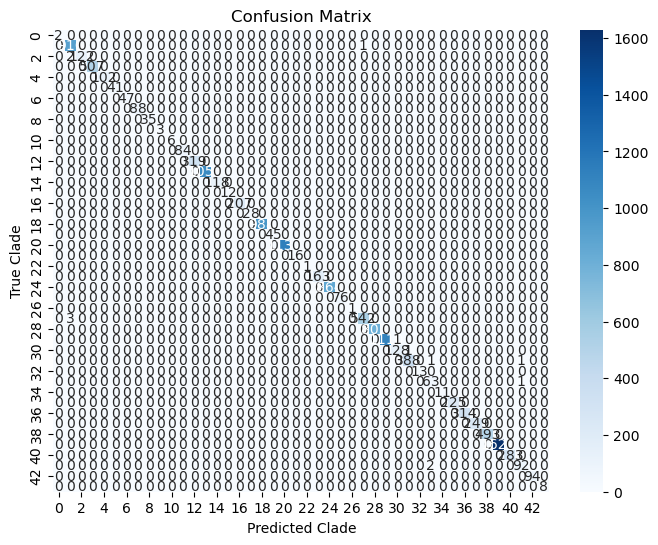

In [50]:
# Confusion Matrix with Seaborn
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)

# Create a new figure for the confusion matrix
plt.figure(figsize=(8, 6))

# Create heatmap using seaborn
heatmap(cm, annot=True, fmt="d", cmap="Blues") # Customize heatmap with annotations, format, and colormap

# Add labels and title
plt.xlabel("Predicted Clade")
plt.ylabel("True Clade")
plt.title("Confusion Matrix")

# Show the confusion matrix
plt.show()

End the timer

In [51]:
# End timing
end_time = time.time()

In [52]:
# Calculate and print total training and validation runtime
total_time = end_time - start_time
print(f"\nTotal training and validation runtime: {total_time:.2f} seconds")


Total training and validation runtime: 774.47 seconds


## Feature Importance

In [53]:
# Feature Importance Analysis

importances = model.feature_importances_

# Map feature indices back to k-mers
kmer_names = process_chunk.ohe.get_feature_names_out()  # Get k-mer names from the encoder

feature_importances = pd.DataFrame({'kmer': kmer_names, 'importance': importances})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)

# Display the top N most important k-mers
N = 20  # You can adjust this to show more or fewer k-mers
print("\nTop", N, "most important k-mers:")
display(feature_importances.head(N))


Top 20 most important k-mers:


,kmer,importance
1546,x0_gcataa,0.003569
1890,x0_gtgcaa,0.003305
633,x0_atccct,0.003017
1478,x0_gatcta,0.002951
1410,x0_gactgg,0.002939
1852,x0_gtcaaa,0.002861
937,x0_catgtc,0.002732
122,x0_aagaga,0.002666
65,x0_aacaat,0.002636
2292,x0_tgacca,0.002603


# 5.0 Test

## 5.1 Load and Prepare Unseen Test Data

In [54]:
# Parse the FASTA file for the new dataset
test_records = list(SeqIO.parse("/home/ajvilleg/Netdrive/AI/GISAID/EpiFlu_Test/29-Jul-2024_Canada/gisaid_epiflu_sequence_29-Jul-2024_Canada.fasta", "fasta"))

In [55]:
# Check for duplicates before extracting details
duplicate_indices, duplicate_headers = check_duplicate_headers(test_records)
if duplicate_indices:
    print("Warning: Found the following duplicate FASTA headers:")
    for header in duplicate_headers:
        print(header)
    print("One copy of each duplicate record will be kept.")

    # Create a set of unique indices to keep
    indices_to_keep = set(range(len(test_records))) - set(duplicate_indices)

    # Filter the records list
    test_records = [record for i, record in enumerate(test_records) if i in indices_to_keep]
    print("Duplicate records have been removed, keeping one copy of each.")

A/Canada/NovaScotia/32049/2022|EPI_ISL_18654370|A_/_H3N2||NA|2022-11-30|3C.2a1b.2a.2a.1b
A/Saskatchewan/SKFLU365394/2024|EPI_ISL_19045711|A_/_H1N1|pdm09|NA|2024-03-21|6B.1A.5a.2a.1
A/Saskatchewan/SKFLU365394/2024|EPI_ISL_19045711|A_/_H1N1|pdm09|HA|2024-03-21|6B.1A.5a.2a.1
A/Saskatchewan/SKFLU366754/2024|EPI_ISL_19045714|A_/_H3N2||NA|2024-03-26|3C.2a1b.2a.2a.3a.1
A/Saskatchewan/SKFLU366754/2024|EPI_ISL_19045714|A_/_H3N2||HA|2024-03-26|3C.2a1b.2a.2a.3a.1
A/Saskatchewan/SKFLU366639/2024|EPI_ISL_19045715|A_/_H1N1|pdm09|NA|2024-03-26|6B.1A.5a.2a.1
A/Saskatchewan/SKFLU366639/2024|EPI_ISL_19045715|A_/_H1N1|pdm09|HA|2024-03-26|6B.1A.5a.2a.1
A/Saskatchewan/SKFLU365637/2024|EPI_ISL_19045712|A_/_H1N1|pdm09|NA|2024-03-22|6B.1A.5a.2a.1
A/Saskatchewan/SKFLU365637/2024|EPI_ISL_19045712|A_/_H1N1|pdm09|HA|2024-03-22|6B.1A.5a.2a.1
A/Saskatchewan/SKFLU365710/2024|EPI_ISL_19045713|A_/_H3N2||NA|2024-03-22|3C.2a1b.2a.2a.3a.1
A/Saskatchewan/SKFLU365710/2024|EPI_ISL_19045713|A_/_H3N2||HA|2024-03-22|3C.2a1b.2a

In [56]:
# Extract the details from the description of each record
test_data = []

# Iterate through records for every pair for NA and HA segments
for record1, record2 in zip(test_records[::2], test_records[1::2]):
    description1 = record1.description.split('|')
    description2 = record2.description.split('|')

    # Assume the isolate name is the same for both segments
    isolate_name1 = description1[0].strip()
    isolate_name2 = description2[0].strip()
    if isolate_name1 != isolate_name2:
        print(f"Isolate names do not match: {isolate_name1} vs {isolate_name2}")
        raise ValueError("Isolate names do not match")

    # Assume the isolate ID is the same for both segments
    isolate_id1 = description1[1].strip()
    isolate_id2 = description2[1].strip()
    if isolate_id1 != isolate_id2:
        print(f"Isolate IDs do not match: {isolate_id1} vs {isolate_id2}")
        raise ValueError("Isolate IDs do not match")

    # Assume the flu type is the same for both segments
    flu_type1 = description1[2].strip()
    flu_type2 = description2[2].strip()
    if flu_type1 != flu_type2:
        print(f"Flu types do not match: {flu_type1} vs {flu_type2}")
        raise ValueError("Flu types do not match")

    # Assume the lineage is the same for both segments
    lineage1 = description1[3].strip()
    lineage2 = description2[3].strip()
    if lineage1 != lineage2:
        print(f"Lineages do not match: {lineage1} vs {lineage2}")
        raise ValueError("Lineages do not match")

    # The segment labels are different for NA and HA segments
    segment1 = description1[4].strip()
    segment2 = description2[4].strip()  

    # Assume the collection date is the same for both segments
    collection_date1 = description1[5].strip()
    collection_date2 = description2[5].strip()
    if collection_date1 != collection_date2:
        print(f"Collection dates do not match: {collection_date1} vs {collection_date2}")
        raise ValueError("Collection dates do not match")

    # Assume the clade is the same for both segments. This is important as this will be our label for classification
    clade1 = description1[6].strip()
    clade2 = description2[6].strip()
    if clade1 != clade2:
        print(f"Clades do not match: {clade1} vs {clade2}")
        raise ValueError("Clades do not match")

    # The sequences will be different corresopnding to the NA and HA segments
    sequence1 = str(record1.seq)
    sequence2 = str(record2.seq)
    if segment1 == 'HA':
        sequence_ha = sequence1
        sequence_na = sequence2
    else: # segment2 == 'HA'
        sequence_ha = sequence2
        sequence_na = sequence1
    test_data.append([isolate_name1, isolate_id1, flu_type1, lineage1, sequence_ha, sequence_na, collection_date1, clade1])

test_df = pd.DataFrame(test_data, columns=['Isolate_Name', 'Isolate_ID', 'Flu_Type', 'Lineage', 'HA', 'NA', 'Collection Date', 'Clade'])


In [57]:
# Take a look at the data
display(test_df)

,Isolate_Name,Isolate_ID,Flu_Type,Lineage,HA,NA,Collection Date,Clade
0,A/Manitoba739850/2023,EPI_ISL_18784542,A_/_H3N2,,atgaaggctatcattgctttgagcaacattctatgtcttgttttcg...,agtaaagatgaatccaaatcaaaagataataacgattggctctgtt...,2023-11-20,3C.2a1b.2a.2a.3a.1
1,A/Manitoba740484/2023,EPI_ISL_18784543,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-11-23,6B.1A.5a.2a.1
2,A/Manitoba738411/2023,EPI_ISL_18784540,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-11-10,6B.1A.5a.2a.1
3,A/Manitoba738222/2023,EPI_ISL_18784541,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-11-09,6B.1A.5a.2a.1
4,A/Manitoba/RV01257/2023,EPI_ISL_18899238,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-11-09,6B.1A.5a.2a.1
...,...,...,...,...,...,...,...,...
3092,A/Manitoba/RV00466/2023,EPI_ISL_18022102,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagtcatgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-05-07,6B.1A.5a.2a
3093,A/Manitoba/RV00399/2023,EPI_ISL_18022085,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagtcatgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-04-12,6B.1A.5a.2a
3094,A/British_Columbia/RV2470/2015,EPI_ISL_212963,A_/_H3N2,,ggataattctattaaccatgaagactatcattgctttgagctacat...,agtaaagatgaatccaaatcaaaagataataacgattggctctgtt...,2015-09-13,3C.2a
3095,A/Manitoba/RV00543/2023,EPI_ISL_18022139,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttatgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttctgt...,2023-05-25,6B.1A.5a.2a.1


In [58]:
# Extract Type using regular expressions
test_df['Type'] = test_df['Flu_Type'].astype(str).str.extract(r'(A|B|C)').fillna('')

In [59]:
# Extract H_Subtype and N_Subtype with updated regex, allowing for one or more digits after H or N.
test_df['H_Subtype'] = test_df['Flu_Type'].astype(str).str.extract(r'(H\d+)').fillna('')
test_df['N_Subtype'] = test_df['Flu_Type'].astype(str).str.extract(r'(N\d+)').fillna('')
print(test_df['H_Subtype'].value_counts().to_markdown(numalign="left", stralign="left"))
print(test_df['N_Subtype'].value_counts().to_markdown(numalign="left", stralign="left"))

| H_Subtype   | count   |
|:------------|:--------|
| H3          | 1676    |
| H1          | 1419    |
| H5          | 1       |
| H7          | 1       |
| N_Subtype   | count   |
|:------------|:--------|
| N2          | 1679    |
| N1          | 1417    |
| N9          | 1       |


In [60]:
# Take a look at the data again
display(test_df)

,Isolate_Name,Isolate_ID,Flu_Type,Lineage,HA,NA,Collection Date,Clade,Type,H_Subtype,N_Subtype
0,A/Manitoba739850/2023,EPI_ISL_18784542,A_/_H3N2,,atgaaggctatcattgctttgagcaacattctatgtcttgttttcg...,agtaaagatgaatccaaatcaaaagataataacgattggctctgtt...,2023-11-20,3C.2a1b.2a.2a.3a.1,A,H3,N2
1,A/Manitoba740484/2023,EPI_ISL_18784543,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-11-23,6B.1A.5a.2a.1,A,H1,N1
2,A/Manitoba738411/2023,EPI_ISL_18784540,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-11-10,6B.1A.5a.2a.1,A,H1,N1
3,A/Manitoba738222/2023,EPI_ISL_18784541,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-11-09,6B.1A.5a.2a.1,A,H1,N1
4,A/Manitoba/RV01257/2023,EPI_ISL_18899238,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-11-09,6B.1A.5a.2a.1,A,H1,N1
...,...,...,...,...,...,...,...,...,...,...,...
3092,A/Manitoba/RV00466/2023,EPI_ISL_18022102,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagtcatgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-05-07,6B.1A.5a.2a,A,H1,N1
3093,A/Manitoba/RV00399/2023,EPI_ISL_18022085,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagtcatgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-04-12,6B.1A.5a.2a,A,H1,N1
3094,A/British_Columbia/RV2470/2015,EPI_ISL_212963,A_/_H3N2,,ggataattctattaaccatgaagactatcattgctttgagctacat...,agtaaagatgaatccaaatcaaaagataataacgattggctctgtt...,2015-09-13,3C.2a,A,H3,N2
3095,A/Manitoba/RV00543/2023,EPI_ISL_18022139,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttatgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttctgt...,2023-05-25,6B.1A.5a.2a.1,A,H1,N1


## 5.2 EDA

### 5.2.1 Dataframe structure

In [61]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3097 entries, 0 to 3096
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Isolate_Name     3097 non-null   object
 1   Isolate_ID       3097 non-null   object
 2   Flu_Type         3097 non-null   object
 3   Lineage          3097 non-null   object
 4   HA               3097 non-null   object
 5   NA               3097 non-null   object
 6   Collection Date  3097 non-null   object
 7   Clade            3097 non-null   object
 8   Type             3097 non-null   object
 9   H_Subtype        3097 non-null   object
 10  N_Subtype        3097 non-null   object
dtypes: object(11)
memory usage: 266.3+ KB


In [62]:
# Convert all columns to strings except Collection Date
test_df = test_df.astype(str)

# Convert "Collection Date" column to date
test_df["Collection Date"] = pd.to_datetime(test_df["Collection Date"])

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3097 entries, 0 to 3096
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Isolate_Name     3097 non-null   object        
 1   Isolate_ID       3097 non-null   object        
 2   Flu_Type         3097 non-null   object        
 3   Lineage          3097 non-null   object        
 4   HA               3097 non-null   object        
 5   NA               3097 non-null   object        
 6   Collection Date  3097 non-null   datetime64[ns]
 7   Clade            3097 non-null   object        
 8   Type             3097 non-null   object        
 9   H_Subtype        3097 non-null   object        
 10  N_Subtype        3097 non-null   object        
dtypes: datetime64[ns](1), object(10)
memory usage: 266.3+ KB


### 5.2.2 Describe

In [63]:
test_df.describe()

,Collection Date
count,3097
mean,2021-08-15 23:55:48.918308096
min,2009-04-16 00:00:00
25%,2022-03-25 00:00:00
50%,2022-12-13 00:00:00
75%,2023-12-11 00:00:00
max,2024-06-16 00:00:00


### 5.2.3 Duplicated rows

In [64]:
# Check for duplicated rows in test data
print(f'test_df has {test_df.duplicated().sum()} duplicate rows')
display(test_df[test_df.duplicated()])
# Drop duplicates and check again
test_df.drop_duplicates(inplace=True)
print(f'test_df has {test_df.duplicated().sum()} duplicate rows')

test_df has 0 duplicate rows


,Isolate_Name,Isolate_ID,Flu_Type,Lineage,HA,NA,Collection Date,Clade,Type,H_Subtype,N_Subtype


test_df has 0 duplicate rows


### 5.2.4 Missing values / NaN / Empty Strings

In [65]:
# Check for missing values and empty strings
print("NaN values in test_df:")
print(test_df.isnull().sum())  # Check for NaN values
print("\nEmpty string values in test_df:")
for col in test_df.select_dtypes(include=['object']):  # Iterate over columns with string datatype
    print(f"{col}: {(test_df[col] == '').sum()}")     # Count empty strings

NaN values in test_df:
Isolate_Name       0
Isolate_ID         0
Flu_Type           0
Lineage            0
HA                 0
NA                 0
Collection Date    0
Clade              0
Type               0
H_Subtype          0
N_Subtype          0
dtype: int64

Empty string values in test_df:
Isolate_Name: 0
Isolate_ID: 0
Flu_Type: 0
Lineage: 1681
HA: 0
NA: 0
Clade: 3
Type: 0
H_Subtype: 0
N_Subtype: 0


In [66]:
# Drop rows with nulls or empty strings in Clade, ignore Lineage nulls/empty strings
test_df.replace('', pd.NA, inplace=True)  # Replace empty strings with NaN
test_df.dropna(subset=['Clade'], inplace=True)  # Drop rows where Clade is NaN

In [67]:
# Check for missing values and empty strings
print("NaN values in test_df:")
print(test_df.isnull().sum())  # Check for NaN values
print("\nEmpty string values in test_df:")
for col in test_df.select_dtypes(include=['object']):  # Iterate over columns with string datatype
    print(f"{col}: {(test_df[col] == '').sum()}")     # Count empty strings

NaN values in test_df:
Isolate_Name          0
Isolate_ID            0
Flu_Type              0
Lineage            1680
HA                    0
NA                    0
Collection Date       0
Clade                 0
Type                  0
H_Subtype             0
N_Subtype             0
dtype: int64

Empty string values in test_df:
Isolate_Name: 0
Isolate_ID: 0
Flu_Type: 0
Lineage: 0
HA: 0
NA: 0
Clade: 0
Type: 0
H_Subtype: 0
N_Subtype: 0


### 5.2.5 Class Imbalance

#### Clade Imbalance

In [68]:
test_df['Clade'].value_counts()

Clade
6B.1A.5a.2a.1         682
6B.1A.5a.2a           475
3C.2a1b.2a.2a.1b      351
3C.2a1b.2a.2a.3a.1    315
3C.2a1b.2a.2b         267
3C.2                  178
6B.1                  142
3C.2a1b.2a.2a         113
3C.2a1b.2a.2a.1        84
3C.2a2                 70
3C.2a                  49
3C.3a                  45
3C.2a1b.1              38
3C.3a1                 29
6B.1A                  26
3C.2a1b.2              24
6B.1A.5b               23
3C.2a1b.2b             21
3C.2a1                 20
3C.2a1b.2a.2a.1a       16
6B.1A.1                16
3C.2a1b.2a.2a.3b       12
6B.1A.5a               11
3C.2a1b.2a.2a.3        10
6B.1A.6                 9
6B.1A.5a.1              8
3C.2a1b.1b              8
3C.2a3                  7
unassigned              7
6B.1A.5a.2              7
6B.1A.2                 6
3C.2a1b.2a.2c           4
6B.1A.7                 4
6B.1A.5                 3
3C.2a1b.2a              3
3C.2a1b.1a              3
3C.2a1b.2a.2a.3a        2
3C.2a1b.2a.2a.2         2
3C.2a1

In [69]:
# Drop rows with "unassigned" in 'Clade' from the training data
test_df = test_df[test_df['Clade'] != 'unassigned']  # Filter out rows with label "unassigned"

#### HACK: Drop rows with "2.3.2.1c" in 'Clade' from the training data, as it is not present in the training data 

In [70]:
# HACK: Drop rows with "2.3.2.1c" in 'Clade' from the training data, as it is not present in the training data 
test_df = test_df[test_df['Clade'] != '2.3.2.1c']  # Filter out rows with label "2.3.2.1c"


In [71]:
test_df['Clade'].value_counts()

Clade
6B.1A.5a.2a.1         682
6B.1A.5a.2a           475
3C.2a1b.2a.2a.1b      351
3C.2a1b.2a.2a.3a.1    315
3C.2a1b.2a.2b         267
3C.2                  178
6B.1                  142
3C.2a1b.2a.2a         113
3C.2a1b.2a.2a.1        84
3C.2a2                 70
3C.2a                  49
3C.3a                  45
3C.2a1b.1              38
3C.3a1                 29
6B.1A                  26
3C.2a1b.2              24
6B.1A.5b               23
3C.2a1b.2b             21
3C.2a1                 20
6B.1A.1                16
3C.2a1b.2a.2a.1a       16
3C.2a1b.2a.2a.3b       12
6B.1A.5a               11
3C.2a1b.2a.2a.3        10
6B.1A.6                 9
6B.1A.5a.1              8
3C.2a1b.1b              8
6B.1A.5a.2              7
3C.2a3                  7
6B.1A.2                 6
6B.1A.7                 4
3C.2a1b.2a.2c           4
6B.1A.5                 3
3C.2a1b.2a              3
3C.2a1b.1a              3
3C.2a1b.2a.2a.3a        2
3C.2a1b.2a.2            2
3C.2a1b.2a.2a.2         2
6B.1A.

#### H_Subtype Imbalance

In [72]:
test_df['H_Subtype'].value_counts()

H_Subtype
H3    1673
H1    1413
Name: count, dtype: int64

#### N_Subtype Imbalance

In [73]:
test_df['N_Subtype'].value_counts()

N_Subtype
N2    1676
N1    1410
Name: count, dtype: int64

### 5.2.6 Shape

In [74]:
test_df.shape

(3086, 11)

### 5.2.7 Look at sequence length stats

In [75]:
new_ha_sequence_lengths = test_df.apply(get_sequence_length, axis=1, column="HA")
new_na_sequence_lengths = test_df.apply(get_sequence_length, axis=1, column="NA")
print("Sequence lengths in HA columns:")
new_ha_sequence_lengths.describe()
print("Sequence lengths in NA columns:")
new_na_sequence_lengths.describe()

Sequence lengths in HA columns:


count    3086.000000
mean     1733.002592
std        27.780186
min      1695.000000
25%      1701.000000
50%      1737.000000
75%      1754.000000
max      1791.000000
dtype: float64

Sequence lengths in NA columns:


count    3086.000000
mean     1433.303629
std        18.097149
min      1369.000000
25%      1410.000000
50%      1433.000000
75%      1441.000000
max      1483.000000
dtype: float64

## 5.3 K-mers and k-mer encoding

In [76]:
# Create an empty dictionary to store kmers for each sequence in the new dataset (identified by row index)
test_kmer_dict = {}

In [77]:
# Extract k-mers from each sequence and store them in the dictionary
for i, row in test_df.iterrows():
    # Extract kmers from HA sequence (assuming it exists)
    ha_kmers = []
    if "HA" in row:  # Check if "HA" column exists
        sequence = str(row["HA"])
        ha_kmers = get_kmers(sequence, kmer_length)

    # Store kmers separately in the dictionary
    test_kmer_dict[i] = {
        "HA": ha_kmers
    }

### 5.3.1 One-Hot Encoding using chunking to optimize memory usage

In [78]:
# One-Hot Encoding on new data using the same kmer chunking logic as before to optimize memory usage
# Apply the same k-mer extraction and chunking as with training data
test_ha_features = []
for i in range(0, len(test_kmer_dict), chunk_size):
    # Get a chunk of data
    chunk_dict = dict(list(test_kmer_dict.items())[i:i + chunk_size])
    
    # Process features for the chunk
    chunk_ha_features = process_chunk(chunk_dict)
    
    # Append features from the chunk
    test_ha_features.extend(chunk_ha_features)

## 5.4 Prediction

In [79]:
# OHE
# Convert list of lists to numpy array
X_new = np.array(test_ha_features)  

In [80]:
# Predict using the trained model
y_pred_new = model.predict(X_new)

# Decode predictions to get the original Clade labels
predicted_clades = le.inverse_transform(y_pred_new)

# Add predicted clades back to new_df
test_df['Predicted_Clade'] = predicted_clades

# Display the data with predictions and true clades
display(test_df[['Isolate_Name', 'Isolate_ID', 'Collection Date', 'Clade', 'Predicted_Clade']])  # Display true and predicted clades

,Isolate_Name,Isolate_ID,Collection Date,Clade,Predicted_Clade
0,A/Manitoba739850/2023,EPI_ISL_18784542,2023-11-20,3C.2a1b.2a.2a.3a.1,3C.2a1b.2a.2a.3a.1
1,A/Manitoba740484/2023,EPI_ISL_18784543,2023-11-23,6B.1A.5a.2a.1,6B.1A.5a.2a.1
2,A/Manitoba738411/2023,EPI_ISL_18784540,2023-11-10,6B.1A.5a.2a.1,6B.1A.5a.2a.1
3,A/Manitoba738222/2023,EPI_ISL_18784541,2023-11-09,6B.1A.5a.2a.1,6B.1A.5a.2a.1
4,A/Manitoba/RV01257/2023,EPI_ISL_18899238,2023-11-09,6B.1A.5a.2a.1,6B.1A.5a.2a.1
...,...,...,...,...,...
3092,A/Manitoba/RV00466/2023,EPI_ISL_18022102,2023-05-07,6B.1A.5a.2a,6B.1A.5a.2a
3093,A/Manitoba/RV00399/2023,EPI_ISL_18022085,2023-04-12,6B.1A.5a.2a,6B.1A.5a.2a
3094,A/British_Columbia/RV2470/2015,EPI_ISL_212963,2015-09-13,3C.2a,3C.2a
3095,A/Manitoba/RV00543/2023,EPI_ISL_18022139,2023-05-25,6B.1A.5a.2a.1,6B.1A.5a.2a.1


## 5.5 Evaluation

In [81]:

# Calculate and display metrics 
y_true_new = le.transform(test_df['Clade']) # Encode true labels

In [82]:
# Evaluate Predictions
print("\n### Model Evaluation on Test Dataset ###")

# Accuracy: Proportion of correctly predicted samples
accuracy = accuracy_score(y_true_new, y_pred_new)
print("Accuracy:", accuracy)

# Precision: Ratio of true positives to all predicted positives
precision = precision_score(y_true_new, y_pred_new, average='weighted') # Weighted average for multi-class
print("Precision:", precision)

# Recall: Ratio of true positives to all actual positives
recall = recall_score(y_true_new, y_pred_new, average='weighted') # Weighted average for multi-class
print("Recall:", recall)

# F1-score: Harmonic mean of precision and recall
f1 = f1_score(y_true_new, y_pred_new, average='weighted') # Weighted average for multi-class
print("F1-score:", f1)


### Model Evaluation on Test Dataset ###
Accuracy: 0.9961114711600778
Precision: 0.9959210835841538
Recall: 0.9961114711600778
F1-score: 0.9959049142071353


#### Classification Report

In [83]:

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true_new, y_pred_new))


Classification Report:
              precision    recall  f1-score   support

           1       0.98      1.00      0.99       178
           2       1.00      0.94      0.97        49
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        38
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00        24
           8       1.00      1.00      1.00         3
          10       1.00      0.50      0.67         2
          11       0.99      1.00      1.00       113
          12       0.98      0.98      0.98        84
          13       1.00      1.00      1.00        16
          14       0.99      0.99      0.99       351
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00        10
          17       1.00      1.00      1.00         2
          18       1.00      1.00      1.00       315
   

#### Confusion Matrix


Confusion Matrix:


<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Clade')

Text(70.72222222222221, 0.5, 'True Clade')

Text(0.5, 1.0, 'Confusion Matrix')

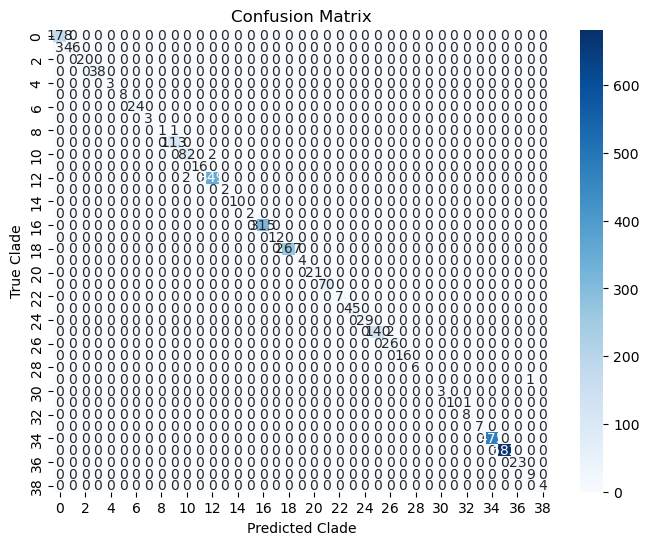

In [84]:
# Confusion Matrix with Seaborn
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true_new, y_pred_new)

# Create a new figure for the confusion matrix
plt.figure(figsize=(8, 6))

# Create heatmap using seaborn
heatmap(cm, annot=True, fmt="d", cmap="Blues") # Customize heatmap with annotations, format, and colormap

# Add labels and title
plt.xlabel("Predicted Clade")
plt.ylabel("True Clade")
plt.title("Confusion Matrix")

# Show the confusion matrix
plt.show()